# Bootstrap for inference in quantitative backtests

#### by Gustavo Soares

This notebook introduces the use of the Bootstrap in quantitative investment strategies. Also, in this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures) as well as in the [FinanceHub's Quantitative Finance Lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Quantitative%20Finance%20Lectures).


## Introduction

The Bootstrap is a statistical method for constructing estiamtes, tests and confidence intervals based on random sampling from the original data. It is an extremely powerful method for assigning measures of uncertainty regarding any particular measurement. It can be allowed to assess and correct bias as well as to estimate variance, confidence intervals, prediction error of estiamtes and predictions. It falls in the broader class of resampling methods. Resampling methods are an indispensable tool in modern statistics as they allow us to obtain information that would not be available from fitting the model only once using the original data sample.

Resampling methods can be computationally expensive, because they involve fitting the same statistical method multiple times using different subsets of the training data. However, due to recent advances in computing power, the computational requirements of resampling methods generally are not prohibitive and resampling methods such as cross-validation and the bootstrap are now an essecial tool in the quantitative finance toolkit. They are both discussed in Chapter 5 of [James, Witten, Hastie, and Tibshirani (2013)](http://faculty.marshall.usc.edu/gareth-james/ISL/).

A great advantage of bootstrap is its simplicity in deriving estimates of standard errors and confidence intervals for complex estimators of complex parameters of the distribution, inclusing estimatores of performance metrics of backtests. In many cases, in quantitative finance it is extremely difficult or impossible to know the true confidence interval of any performance measurement but the bootstrap is not only a simple way of obtaining that but also it can be shown to be asymptotically more accurate, with higher order improvements, than the standard intervals obtained via standard asymptotic approximations. Today, the Bootstrap is the recommended method for constructing tests and confidence intervals and it is hard to think about situation where asymptotic approximation such as standard t-tests would be preferable.

###### Standard Bootstrap

The standard Bootstrap consists in approximating the population distribution by the finite-sample empirical distribution function of the observed data. In its original form, starting with [Efron (1979)](https://projecteuclid.org/download/pdf_1/euclid.aos/1176344552), it assumes the data is drawn from an independent and identically distributed (IID) random variable. So, the standard Bootstrap consists of randomly taking subsamples from the original data with replacement (taking sub-samples without replacement is a related resampling method called subsampling orginally proposed by [Politis and Romano (1994a)](https://www.jstor.org/stable/2242497?seq=1) in order to reconstruct different versions of the original observed data set (and of equal size to the observed data set).

###### Block Bootstrap for time series data

However, the IID assumption is a problem for the application of the standard bootstrap in finance. Since financial time series and investment strategies backtest have some sort of time dependance, the standrad Bootstrap would not apply. A solution to this problem is the use of the **block bootstrap**. Instead of resampling observation by observation like the standard bootstrap, the block bootstrap tries to replicate the correlation by resampling instead blocks of data. So, time you resample an observation from the original dataset, pick also adjacent observations at the same time in order not to break temporal dependencies among series values.

Let's import some things we are going to need and get started with an example.

In [1]:
import numpy as np
import pandas as pd
from bloomberg import BBG
from portfolio.performance import FHPerformance
import matplotlib.pyplot as plt
bbg = BBG()
fhp = FHPerformance()

## Example set up

Let's start by importing data on Brazilian assets such as the Ibovespa (ibov) stock market index and indices for real bonds (ntnbs) and nominal bonds (ntnfs). Let's also collect data on the cost funding rate, the cdi. using the [FinanceHub Bloomberg API](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg):

In [2]:
start_date = '2005-1-1'
end_date = '2019-12-31'

df = bbg.fetch_series(securities=['IBOV Index', 'BZRFIMAB Index','BZRFIRFM Index','BZACCETP Index'],
                      fields='PX_LAST',
                      startdate=start_date,
                      enddate=end_date)
df = df.rename({'IBOV Index' : 'ibov', 'BZRFIMAB Index' : 'ntnbs', 'BZRFIRFM Index' : 'ntnfs','BZACCETP Index' : 'cdi'},axis=1)
df.to_csv('brazil_assets.csv') # saving the .csv file for those who do not have access to Bloomberg
df.head()

,ibov,ntnbs,ntnfs,cdi
2005-01-03 00:00:00,25722,973.794,2136.65,11.8336
2005-01-04 00:00:00,24848,974.279,2138.1,11.8413
2005-01-05 00:00:00,24691.8,974.87,2139.1,11.849
2005-01-06 00:00:00,24366.9,975.13,2139.28,11.8567
2005-01-07 00:00:00,24747.2,975.713,2141.24,11.8643


Let's now calculate the return in excess of the cost of funding rate for the three assets (stocks, real bonds, and nominal bonds) and then use [FinanceHub's Performance functions]() to calculate some performance metrics:

,ibov,ntnbs,ntnfs
frequency,daily,daily,daily
excess_returns,-0.00448976,0.0333315,0.01864
volatility,0.265042,0.0642256,0.0280482
sharpe,-0.0169398,0.518976,0.664572
sortino,-0.023571,0.574951,0.746813
maxDD,-0.763481,-0.216376,-0.107069
maxDD_to_vol_ratio,-2.8806,-3.36901,-3.81731
from_date,03-Jan-05,03-Jan-05,03-Jan-05
to_date,31-Dec-19,31-Dec-19,31-Dec-19
n_obs,3766,3766,3766


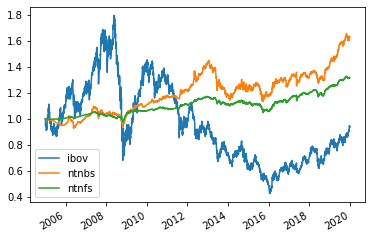

In [3]:
er = (df.pct_change(1).subtract(df['cdi'].pct_change(1),axis=0)).drop('cdi',axis=1)
er_ts = (1+er).fillna(1).cumprod()
er_ts.plot()
fhp.get_perf_table(er_ts)

#### A simple momentum strategy

Let's now suppose that we create a simple momentum strategy. We will look at the 3M momentum of an asset class and invest, targeting 10% volatility, always in the asset class with highest momentum. We will hold that position for a month. Let's do that with the code below:

C:\Users\Gustavo\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


,ibov,ntnbs,ntnfs,mom_str
frequency,daily,daily,daily,daily
excess_returns,-0.00157376,0.0348898,0.0192662,0.0781361
volatility,0.265218,0.0647663,0.0282758,0.122272
sharpe,-0.00593386,0.538702,0.681365,0.639035
sortino,-0.00822555,0.596622,0.766679,0.754344
maxDD,-0.763481,-0.216376,-0.107069,-0.379506
maxDD_to_vol_ratio,-2.8787,-3.34088,-3.78658,-3.10379
from_date,06-Apr-05,06-Apr-05,06-Apr-05,06-Apr-05
to_date,31-Dec-19,31-Dec-19,31-Dec-19,31-Dec-19
n_obs,3702,3702,3702,3702


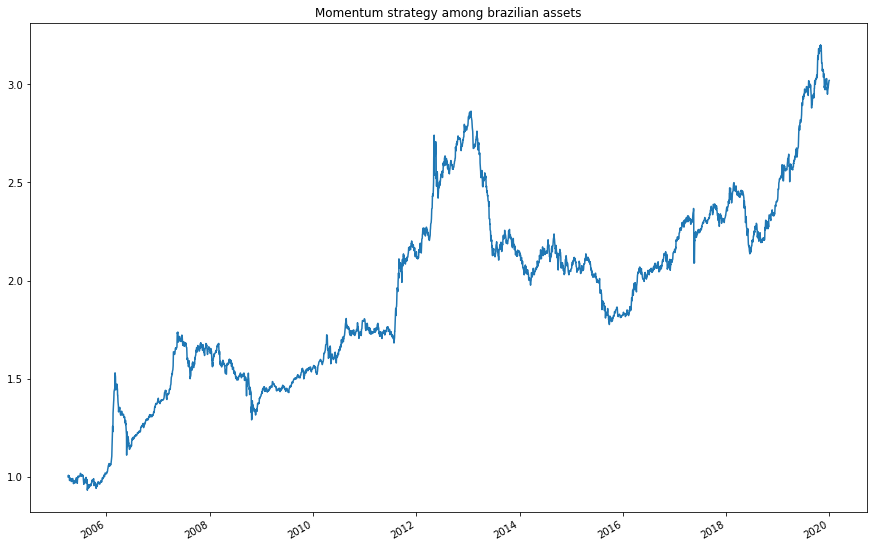

In [4]:
def get_momentum_strategy(df):
    # calculate the volatilities using an EWMA with 3M half-life and give it one day lag
    vols = (np.log(df).diff(1).ewm(halflife=63).std()*np.sqrt(252)).shift(1)
    # calculate the past three month returns annualized
    ret = ((1+df.pct_change(63))**(12/3)-1).shift(1)
    # calculate momentum signal based on the ratio ret/vol
    mom_signal = (ret/vols).dropna()

    # BACKTEST
    # initialize
    mom_ts = pd.Series(index=mom_signal.index)
    start_date = mom_ts.index[0]
    mom_ts.loc[start_date]=1
    top_asset = mom_signal.loc[start_date].idxmax()
    quant = ((0.1/vols.loc[start_date,top_asset])*mom_ts.loc[start_date])/df.loc[start_date,top_asset]

    for tdy,yst in zip(mom_ts.index[1:],mom_ts.index[:-1]): # loop over the following days
        pnl = quant*(df.loc[tdy,top_asset] - df.loc[yst,top_asset])
        mom_ts[tdy] = mom_ts[yst] + pnl

        # rebalance at month-end
        if tdy.month != yst.month:
            top_asset = mom_signal.loc[tdy].idxmax()
            quant = ((0.1/vols.loc[tdy,top_asset])*mom_ts.loc[tdy])/df.loc[tdy,top_asset]
    
    return mom_ts

mom_ts = get_momentum_strategy(er_ts)
mom_ts.plot(title='Momentum strategy among brazilian assets',figsize=(15,10))
fhp.get_perf_table(pd.concat([er_ts,mom_ts.to_frame('mom_str')],axis=1,sort=True))

The results look pretty good. It seems like a momentum strategy among brazilian asset works pretty well!! We are generating about 8% a year over CDI with a volatility around 12%, giving a Sharpe ratio of about 0.64 which is pretty remarkable for a "multi-mercado" fund. However, how reliable are these estimates? Do you trust them? Let's use the Bootstrap to assess exactly that.

## Moving block bootstrap

Our data consists of a sequence $\{X_{t}\}^{T}_{t=0}$ of $3 \times 1$ vectors $X_{t} = [ibov_{t},ntnbs_{t},ntnfs_{t}]'$. The moving block bootstrap (MBB), proposed by Kunsch (1989) and Liu and Singh (1992). The idea is to resamples blocks randomly, with replacement. The blocks can be overlapping and they have the same uniform distribution of being drawn.

The blocks have a fixed *block size*. In statistics, there are different approaches for choosing the size of blocks for the block bootstrap. See [Politis and White (2003)](http://www.math.ucsd.edu/~politis/SBblock-revER.pdf) for example. However, here we will use a more or less intuitive approach of taking 1 year of data (252 bdays) as our block size. Intuitively, this seems enough for dependance to dissipate in financial time series.

###### Our first bootstrap sample

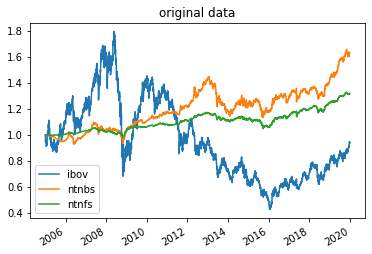

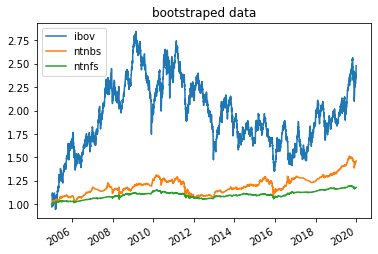

C:\Users\Gustavo\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


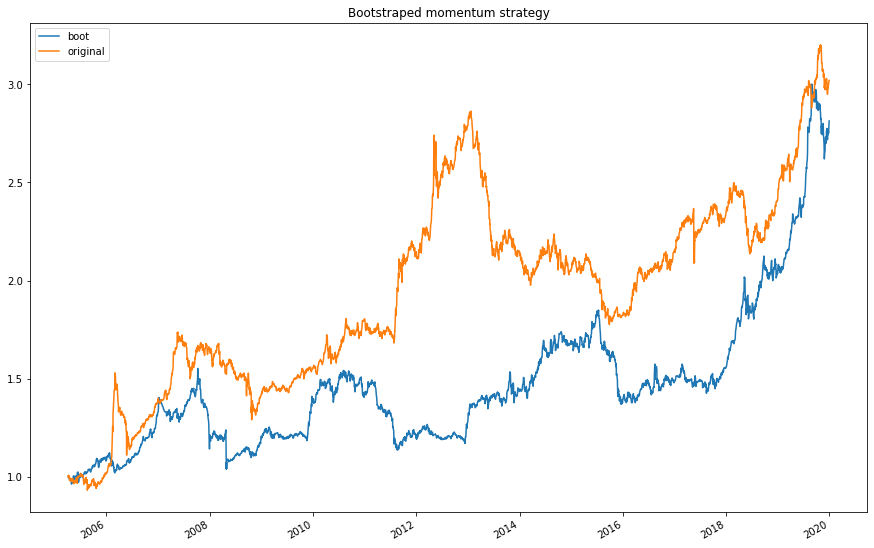

,boot,original
frequency,daily,daily
excess_returns,0.0729544,0.0781361
volatility,0.116664,0.122272
sharpe,0.625338,0.639035
sortino,0.693534,0.754344
maxDD,-0.329938,-0.379506
maxDD_to_vol_ratio,-2.82811,-3.10379
from_date,06-Apr-05,06-Apr-05
to_date,31-Dec-19,31-Dec-19
n_obs,3702,3702


In [10]:
def get_bootstrap_sample(df,block_size = 252):
    T = df.shape[0]
    bootstrap_sample = pd.DataFrame()
    while bootstrap_sample.shape[0]<T: 
        pick_random_t = np.random.randint(0,T-block_size)
        block_picked = ((df.iloc[pick_random_t:pick_random_t+block_size]).reset_index().drop('index',1)).pct_change(1)
        bootstrap_sample = bootstrap_sample.append(block_picked)
    bootstrap_sample = (1+bootstrap_sample).fillna(1).cumprod()
    bootstrap_sample = bootstrap_sample.iloc[:T]
    bootstrap_sample.index = df.index
    return bootstrap_sample

er_ts.plot(title='original data')
plt.show()

bootstrap_sample = get_bootstrap_sample(er_ts,block_size = 252)
bootstrap_sample.plot(title='bootstraped data')
plt.show()

mom_ts_bootstrap_sample = get_momentum_strategy(bootstrap_sample)
both_ts = pd.concat([mom_ts_bootstrap_sample.to_frame('boot'),mom_ts.to_frame('original')],axis=1,sort=True)
both_ts.plot(title='Bootstraped momentum strategy',figsize=(15,10))
plt.show()
fhp.get_perf_table(both_ts)

###### Bootstrap estimates

Now that we ran our first bootstrap sample. Let's just do that a thousand times!

C:\Users\Gustavo\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


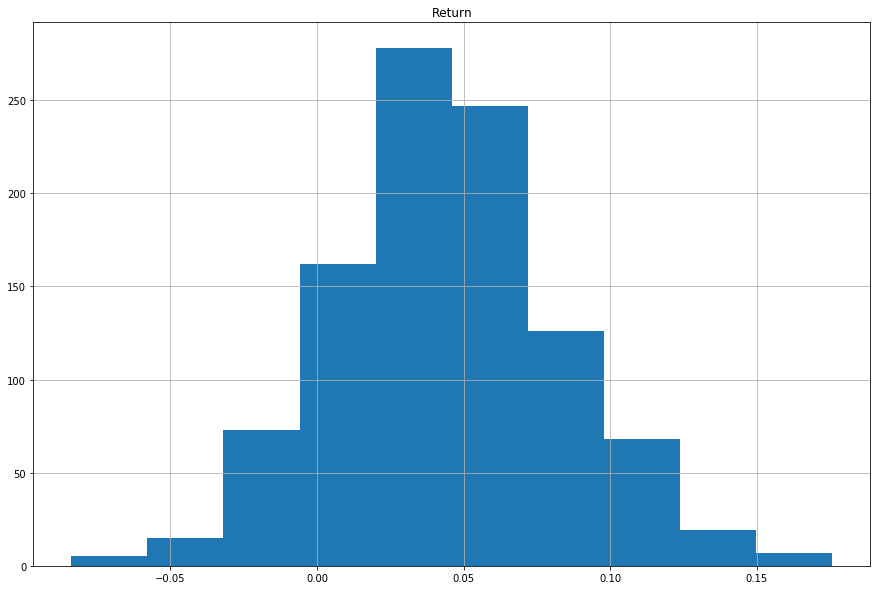

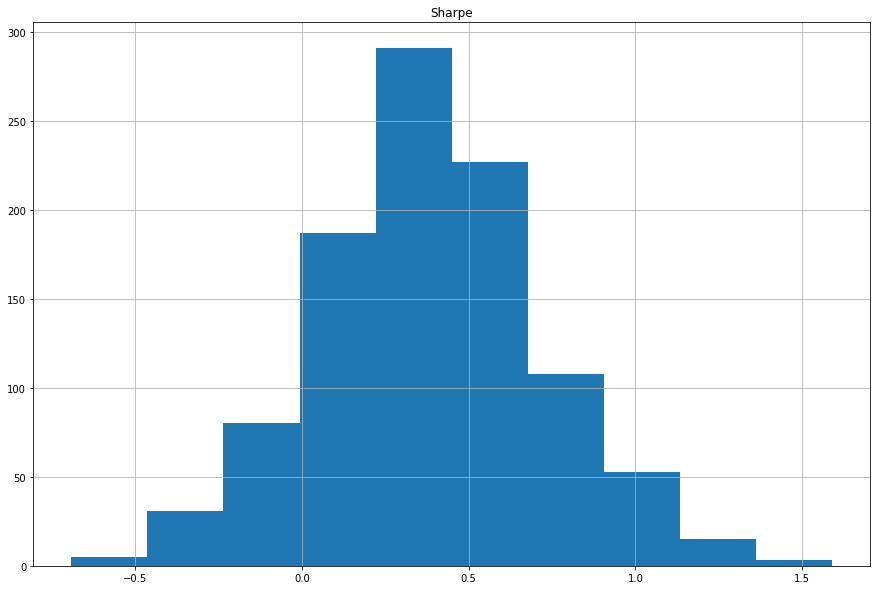

In [6]:
all_bootstrap_samples = pd.DataFrame()
for i in range(1000):
    bootstrap_sample = get_bootstrap_sample(er_ts,block_size = 252)
    mom_ts_bootstrap_sample = get_momentum_strategy(bootstrap_sample)
    perf_table = fhp.get_perf_table(mom_ts_bootstrap_sample)
    perf_table_sample = perf_table.loc[['excess_returns','sharpe']].iloc[:,0].to_frame('sample_%s' % i).T
    all_bootstrap_samples = all_bootstrap_samples.append(perf_table_sample.astype(float))

all_bootstrap_samples['excess_returns'].hist(figsize=(15,10))
plt.title('Return')
plt.show()
all_bootstrap_samples['sharpe'].hist(figsize=(15,10))
plt.title('Sharpe')
plt.show()

In [7]:
all_bootstrap_samples.describe()

,excess_returns,sharpe
count,1000.000000,1000.000000
mean,0.044585,0.384862
std,0.038689,0.335774
min,-0.083838,-0.692799
25%,0.019419,0.164460
50%,0.043823,0.376043
75%,0.067841,0.585475
max,0.175641,1.590630


## Other types of block bootstrap

The circular block bootstrap was proposed by [Politis and Romano (1992)]() and it is very similar to the Moving Bootstrap apart from a technical issue that it uses the entire dataset for resampling while the moving block boostrap never uses the entire start-to-end dataset for drawing its subsamples. [Politis and Romano (1994b)](https://www.ssc.wisc.edu/~bhansen/718/Politis%20Romano.pdf) introduce the stationary block bootstrap with exponentially distributed block sizes. The implementation of these other types of bootstrap can be tricky, but the [arch bootrap package](https://arch.readthedocs.io/en/latest/bootstrap/timeseries-bootstraps.html) makes it easy. Let's see an example with the Stationary Bootstrap applied to our data:

In [8]:
from arch.bootstrap import StationaryBootstrap
all_bootstrap_samples = pd.DataFrame()
bs = StationaryBootstrap(252, er_ts.pct_change(1).dropna().values)
for s in bs.bootstrap(1000):
    full_data = np.concatenate([np.zeros([1,s[0][0].shape[1]]),s[0][0]])    
    bootstrap_sample = pd.DataFrame(index=er_ts.index,columns=er_ts.columns,data=full_data)
    bootstrap_sample = (1+bootstrap_sample).fillna(1).cumprod()
    mom_ts_bootstrap_sample = get_momentum_strategy(bootstrap_sample)
    perf_table = fhp.get_perf_table(mom_ts_bootstrap_sample)
    perf_table_sample = perf_table.loc[['excess_returns','sharpe']].iloc[:,0].to_frame('sample_%s' % i).T
    all_bootstrap_samples = all_bootstrap_samples.append(perf_table_sample.astype(float))
all_bootstrap_samples.describe()

C:\Users\Gustavo\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


,excess_returns,sharpe
count,1000.000000,1000.000000
mean,0.052941,0.451691
std,0.037819,0.321597
min,-0.060562,-0.563459
25%,0.027129,0.234322
50%,0.051446,0.440292
75%,0.078179,0.666688
max,0.197778,1.598686
